In [15]:
import pandas as pd
import numpy as np
import glob
from pomegranate import *
import scipy
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [3]:
column_names = ['BLCODE',
 'SUB',
 'AGE',
 'SEX',
 'YEAR',
 'DAY',
 'TIME',
 'ASH',
 'PRXY_TSA',
 'TSA',
 'MCI',
 'VENT',
 'AVM',
 'COMF',
 'ACT10',
 'ACT20',
 'ACT30',
 'ACT60',
 'MET',
 'CLO',
 'UPHOLST',
 'INSUL',
 'TA_H',
 'TA_M',
 'TA_L',
 'DEWPT',
 'PRTA-B',
 'TG_H',
 'TG_M',
 'TG_L',
 'VEL_H',
 'VEL_M',
 'VEL_L',
 'TURB_H',
 'TURB_M',
 'TURB_L',
 'TAAV',
 'TRAV',
 'TOP',
 'VELAV',
 'VELMAX',
 'TUAV',
 'PA',
 'RH',
 'ET',
 'SET',
 'TSENS',
 'DISC',
 'PMV',
 'PPD',
 'PD_H',
 'PD_M',
 'PD_L',
 'PD_MAX',
 'PCC',
 'PCC_AG',
 'PCS',
 'PCEC1',
 'PCEC2',
 'PCEC3',
 'PCEC4',
 'PCEC5',
 'PCEC6',
 'PCEC7',
 'PCED1',
 'PCED2',
 'PCED3',
 'PCED4',
 'PCED5',
 'PCED6',
 'PCED7',
 'day15_ta',
 'day06_ta',
 'dayav_ta',
 'day15_rh',
 'day06_rh',
 'dayav_rh',
 'day15_et',
 'day06_et',
 'dayav_et']

In [4]:
data_raw = pd.read_csv('6_EXL.csv', sep=',', skiprows=6, skipfooter=4, engine='python', usecols=[i for i in range(80)], header=None, names=column_names)
select = data_raw.apply(lambda r: any(['DIV' in str(e) or 'ACT10' in str(e) for e in r]),axis=1)
data_raw = data_raw[~select].replace('.', np.nan).copy()

data_raw['MCI'] = pd.to_numeric(data_raw['MCI'], errors='coerce')
data_raw['ASH'] = pd.to_numeric(data_raw['ASH'], errors='coerce')
data_raw['TAAV'] = pd.to_numeric(data_raw['TAAV'], errors='coerce')

## To time-series data

In [5]:
# add missing measure time
for index, row in data_raw.iterrows():
    if row['TIME'] is np.nan:
        data_raw.at[index,'TIME'] = data_raw.loc[index-1, 'TIME']

# sort table with year, day, time
data = data_raw.sort_values(by=['YEAR','DAY','TIME'])

In [6]:
## convert ash to categorical
data['ash_cat'] = data.apply(lambda row: -1 if float(row['ASH']) <0 else 0 if float(row['ASH']) == 0 else 1, axis=1)
data = data.dropna(subset=['TAAV', 'ASH', 'MET', 'INSUL', 'TAAV', 'RH', 'dayav_ta', 'dayav_rh'])
features = ['MET', 'INSUL', 'TAAV', 'RH', 'dayav_rh']
data.INSUL = data.INSUL.astype('float')
data.MET = data.MET.astype('float')

## Hidden Markov Model

In [ ]:
# clf = hmm.GaussianHMM(n_components=3, covariance_type='full')
# clf.fit(data['TAAV'].values.reshape(-1,1))

In [ ]:
# result = clf.predict(data['TAAV'].values.reshape(-1,1))
# print(result)
# sum(result==2)


In [ ]:
# sum(data['ash_cat']==1)

## Multivariate feature

In [7]:
## feature param
cold_data = data.loc[data['ash_cat'] == -1]
comf_data = data.loc[data['ash_cat'] == 0]
hot_data  = data.loc[data['ash_cat'] == 1]

mu_cold = []
mu_comf = []
mu_hot  = []



for feature in features:
    mu_cold.append(cold_data[feature].astype('float').mean())
    mu_comf.append(comf_data[feature].astype('float').mean())
    mu_hot.append(hot_data[feature].astype('float').mean())
    
cov = data[features].cov()
cov

# data[['INSUL', 'TAAV']].cov()


,MET,INSUL,TAAV,RH,dayav_rh
MET,9.009009e-05,-2.785430e-05,7.921014e-04,3.589368e-04,1.645389e-30
INSUL,-2.785430e-05,6.776944e-03,-1.458561e-02,1.710728e-02,3.561449e-31
TAAV,7.921014e-04,-1.458561e-02,3.251108e+00,-2.142980e+00,-2.279327e-29
RH,3.589368e-04,1.710728e-02,-2.142980e+00,2.021749e+01,-2.552846e-29
dayav_rh,1.645389e-30,3.561449e-31,-2.279327e-29,-2.552846e-29,2.024043e-28


In [8]:
## Fit 
d_cold = MultivariateGaussianDistribution(mu_cold, cov)
d_comf = MultivariateGaussianDistribution(mu_comf, cov)
d_hot  = MultivariateGaussianDistribution(mu_hot,  cov)


s_cold = State(d_cold, name='cold')
s_comf = State(d_comf, name='comf')
s_hot  = State(d_hot,  name='hot')

pt = 0.9
trans_mat = np.array([[pt, 1-pt, 0], [1-pt, 2*pt-1, 1-pt], [0, 1-pt,pt]])
starts = np.array([0.1, 0.8, 0.1])
ends   = np.array([0, 1, 0])
dists = [d_cold, d_comf, d_hot]
model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)

In [11]:
y = model.predict(data[features])
y_pred = [i-1 for i in y]

Confusion matrix, without normalization
[[ 95  17   0]
 [173  69   0]
 [ 70  20   0]]


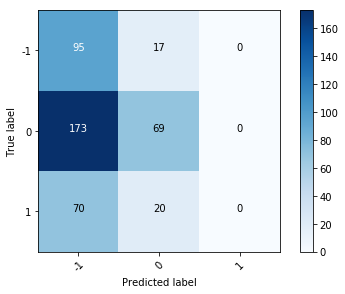

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_mat = confusion_matrix(data['ash_cat'], y_pred)
plot_confusion_matrix(conf_mat, ['-1','0','1'], title='')
plt.savefig('confmatHMM.png')

In [144]:
x_train = []

features = ['MET', 'INSUL', 'TAAV', 'RH']
for index, row in data.iterrows():
    sample = []
    for feature in features:
        sample.append(row[feature])
    x_train.append(sample)
    
mul_hmm = HiddenMarkovModel('Thermal').from_samples(MultivariateGaussianDistribution, n_components=3, X=x_train, algorithm='baum-welch')

# d_cold = MultivariateGaussianDistribution()
# d_comf = MultivariateGaussianDistribution(name='comf',d=8)
# d_hot  = MultivariateGaussianDistribution(name='hot' ,d=8)

# s_cold = State(d_cold, name='cold')
# s_comf = State(d_comf, name='comf')
# s_hot  = State(d_hot,  name='hot')


In [146]:
counts = 0
y_pred = mul_hmm.predict(data[features])
for index, row in data.iterrows():
    if y_pred[i]-1 == row['ash_cat']:
        counts = counts + 1

accuracy = counts / data.shape[0]
print(accuracy)


0.545045045045045


In [48]:
# print(mu_cold)
# print(mu_comf)
# print(mu_hot)
# data.loc[131,:]